In [1]:
import warnings
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('Housing.csv')

In [3]:
df.head(5)

,0.00632,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
1,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
2,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


In [4]:
X = df.values[:,:-1]
y = df.values[:, -1]

In [5]:
class Linear_Regression:
    def __init__(self, X, y, max_iteration, epsilon, lambda_, learning_rate, sgd, gd=True, regularization=True, batch_size = None) -> None:
        self.X = X
        self.y = y
        self.max_iteration = max_iteration
        self.epsilon = epsilon
        self.lambda_ = lambda_
        self.learning_rate = learning_rate
        self.sgd = sgd
        self.gd = gd
        self.regularization = regularization
        self.batch_size = batch_size

    def split_data(self):
      X_train, X_test, y_train, y_test = train_test_split(self.X,
                                                          self.y,
                                                          test_size=0.3,
                                                          shuffle= True)
      return X_train, X_test, y_train, y_test

    def add_X0(self, X):
      return np.column_stack([np.ones([X.shape[0], 1]), X])

    def normalize_train(self,X):
      mean = np.mean(X, axis = 0)
      std = np.std(X, axis = 0)
      X = (X - mean) / std
      X = self.add_X0(X)
      return X, mean, std

    def normalize_test(self, X, mean, std):
      X = (X - mean) / std
      X = self.add_X0(X)
      return X

    def rank(self, X):
      u, s, v = np.linalg.svd(X)
      return len([x for x in s if x > 0.0005])

    def check_fullRank(self,X):
      rank = self.rank(X)
      if rank == min(X.shape):
        self.full_rank = True
        print("it is full rank")
      else:
        self.full_rank = False
        print("it is not full rank")

    def check_lowRank(self, X):
      if X.shape[0] < X.shape[1]:
        self.low_rank = True
        print("it is low rank")
      else:
        self.low_rank = False
        print("it is not low rank")

    def closed_form_solution(self, X, y):
    #Adding the penalty term as L2 Norm
      if self.regularization == True:
        self.theta = np.linalg.inv(X.T.dot(X) + self.lambda_ * np.identity(X.shape[1])).dot(X.T).dot(y)
      else:
        self.theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

      return self.theta

    def predict(self, X):
      return X.dot(self.theta)

    def sse(self, X, y):
      y_hat = self.predict(X)
      return ((y_hat - y) ** 2).sum()

    def cost_function(self, X, y):
      loss = self.sse(X, y)
      return loss / 2
    
    def cost_derivative(self, X, y):
      if self.regularization == 'ridge':
        y_hat = self.predict(X)
        return (X.T.dot(y_hat - y) + self.lambda_ * self.theta)
      elif self.regularization == 'lasso':
        y_hat = self.predict(X)
        return (X.T.dot(y_hat - y)+ np.sign(self.theta))
      else:
        y_hat = self.predict(X)
        return X.T.dot(y_hat - y)

    def gradient_descent(self, X, y):
      errors = []
      prev_error = float("inf")

      for t in tqdm(range(self.max_iteration), colour = 'blue'):
        self.theta -= self.learning_rate * self.cost_derivative(X, y)
        error = self.cost_function(X, y)
        errors.append(error)

        if abs(error - prev_error) < self.epsilon:
          print("Model stopped learning")
          break

      self.plot_rmse(errors)
      
    def stocastic_gradient_descent(self, X, y):
      errors = []
      prev_error = float("inf")
      
      print("Batch size: " + str(int(len(y) * self.batch_size)))
      
      self.slice_rowsX = int(X.shape[0] * self.batch_size)
      self.slice_rowsy = int(len(y) * self.batch_size)
      
      #slice X till batch_size
      sgdX = X[:self.slice_rowsX, :]
      sgdy = y[:self.slice_rowsy]

      for t in tqdm(range(self.max_iteration), colour = 'blue'):
        self.theta -= self.learning_rate * self.cost_derivative(sgdX, sgdy)
        error = self.cost_function(sgdX, sgdy)
        errors.append(error)

        if abs(error - prev_error) < self.epsilon:
          print("Model stopped learning")
          break

      self.plot_rmse(errors)

    def fit(self):
      X_train, X_test, y_train, y_test = self.split_data()
      X_train, mean, std = self. normalize_train(X_train)
      X_test = self.normalize_test(X_test, mean, std)
      self.check_fullRank(X_train)
      self.check_lowRank(X_train)

      if self.full_rank and not self.low_rank and X_train.shape[1] < 1000 and not self.gd and not self.sgd:
          print("Closed form solution")
          self.closed_form_solution(X_train, y_train)
      elif self.gd or self.low_rank:
        print("Gradient Descent")
        self.theta = np.ones(X_train.shape[1])
        self.gradient_descent (X_train, y_train)
      else:
        print("Stochastic Gradient Descent")
        self.theta = np.ones(X_train.shape[1])
        self.stocastic_gradient_descent(X_train, y_train)

      print(self.theta)


    def plot_rmse(self, error_sequence):
        """
        @X: error_sequence, vector of rmse
        @does: Plots the error function
        @return: plot
        """
        # Data for plotting
        s = np.array(error_sequence)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t, s)

        ax.set(xlabel='iterations', ylabel=list(range(len(error_sequence))))
        ax.grid()

        plt.legend(["Error Curve"], bbox_to_anchor=(1.05,1), loc=2, shadow=True)
        plt.show()


In [6]:
# # Closed form solution 
# Regularization = True

# lr = Linear_Regression(X, y, max_iteration=50, epsilon=0.003, learning_rate=0.001, lambda_ = 0.01,
#                       sgd = False, 
#                       gd = False, 
#                       regularization=True)
# lr.fit()

it is full rank
it is not low rank
Closed form solution
[23.12852327 -1.05842412  1.20944861 -0.03238208  0.61853613 -2.16618665
  2.45691201  0.36750303 -3.42648381  2.52923202 -1.90682602 -2.02765425
  0.63148313 -4.18036438]


In [7]:
# # Closed form solution 
# Regularization = False

# lr = Linear_Regression(X, y, max_iteration=50, epsilon=0.003, learning_rate=0.001, lambda_ = 0.01,
#                       sgd = False, 
#                       gd = False, 
#                       regularization=False)
# lr.fit()

it is full rank
it is not low rank
Closed form solution
[22.97252125 -0.32200963  1.09590326  0.18775939  0.85288673 -2.11900843
  2.98063598 -0.19180142 -3.23228198  2.76442341 -2.32531007 -2.2083471
  0.84387409 -3.67353119]


it is full rank
it is not low rank
Gradient Descent


100%|██████████| 1500/1500 [00:00<00:00, 20329.58it/s]


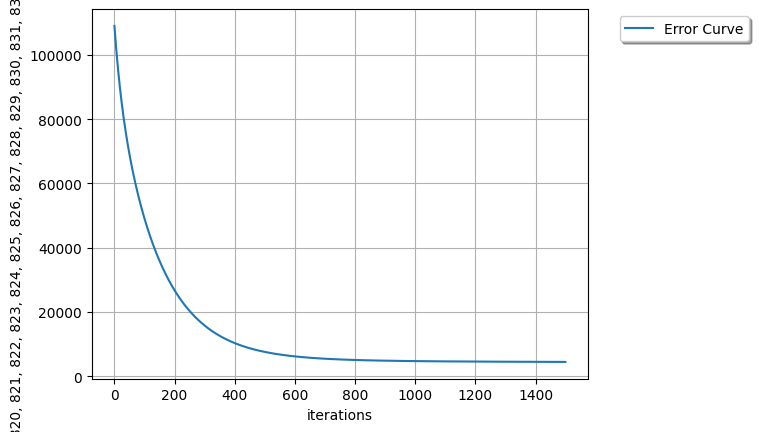

[22.74944254 -0.79500748  0.79187333 -0.07291806  0.81472111 -1.12644489
  3.23815909 -0.15370598 -1.95689735  0.92487887 -0.286432   -1.76933921
  0.91185223 -3.67773204]


In [9]:
# # Gradient Descent 
# # Regularization = lasso
# warnings.filterwarnings('ignore')

# lr = Linear_Regression(X, y, max_iteration=1500, epsilon=0.03, learning_rate=0.00001, lambda_ = 0.01,
#                       sgd = False, 
#                       gd = True, 
#                       regularization='lasso')
# lr.fit()

it is full rank
it is not low rank
Gradient Descent


100%|██████████| 1500/1500 [00:00<00:00, 48875.55it/s]


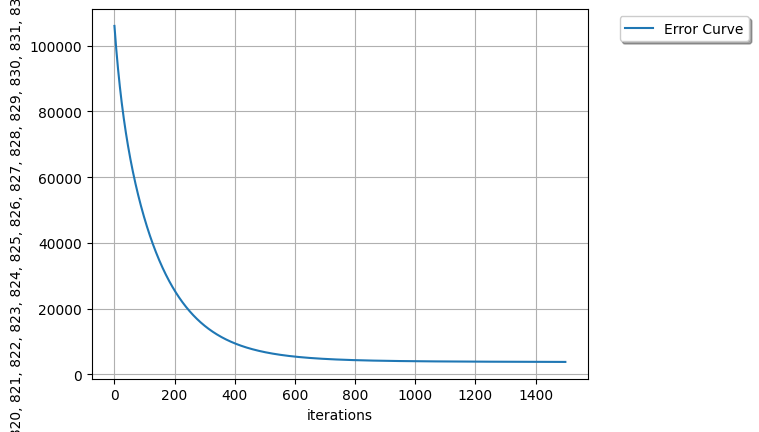

[22.53092872 -0.9299667   0.473728   -0.17303188  0.44617823 -0.78222631
  3.00386535  0.12811334 -1.70756809  1.00364599 -0.66200522 -1.85302365
  1.22212643 -3.57438697]


In [10]:
# # Gradient Descent 
# # Regularization = ridge
# warnings.filterwarnings('ignore')

# lr = Linear_Regression(X, y, max_iteration=1500, epsilon=0.03, learning_rate=0.00001, lambda_ = 0.01,
#                       sgd = False, 
#                       gd = True, 
#                       regularization='ridge')
# lr.fit()

In [69]:
# Gradient Descent 
# Regularization = Fasle
# warnings.filterwarnings('ignore')

# lr = Linear_Regression(X, y, max_iteration=1500, epsilon=0.03, learning_rate=0.00001, lambda_ = 0.01,
#                       sgd = False, 
#                       gd = True, 
#                       regularization=False)

# lr.fit()

In [78]:
# Stocastic Gradient Descent 
# Regularization = True
# warnings.filterwarnings('ignore')

# lr = Linear_Regression(X, y, max_iteration=1500, epsilon=0.03, learning_rate=0.00001, lambda_ = 0.01,
#                       batch_size=0.3,
#                       sgd = True, 
#                       gd = False, 
#                       regularization=True)

# lr.fit()

In [71]:
# Stocastic Gradient Descent 
# Regularization = False
# warnings.filterwarnings('ignore')

# lr = Linear_Regression(X, y, max_iteration=1500, epsilon=0.03, learning_rate=0.00001, lambda_ = 0.01,
#                       batch_size=0.3,
#                       sgd = True, 
#                       gd = False, 
#                       regularization=False)

# lr.fit()